<a href="https://colab.research.google.com/github/mahtabkarami/Projects/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model loaded successfully.


Saving images.jpg to images.jpg


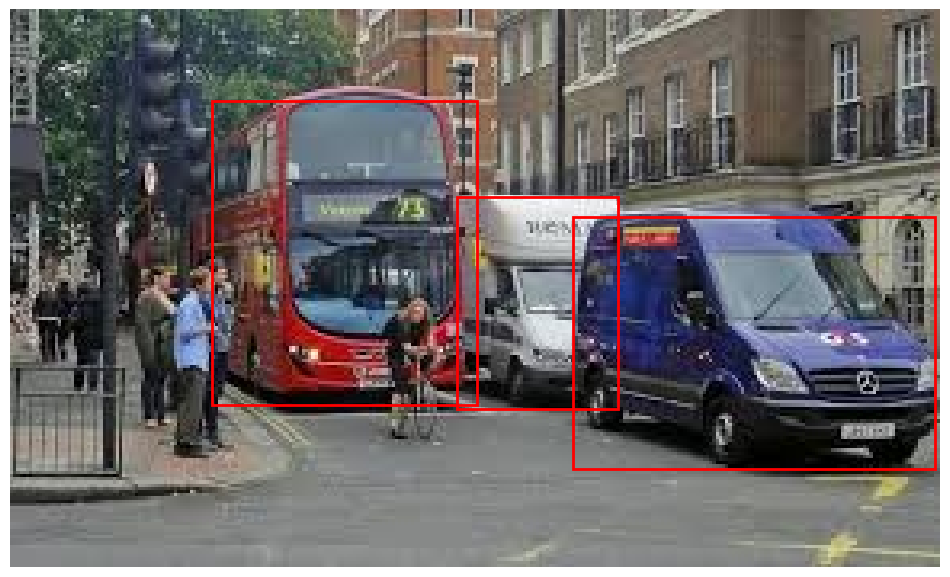

In [3]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Load the pre-trained SSD MobileNet V2 model
model_name = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_file = model_name + '.tar.gz'
model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True)

# Check the directory structure within the extracted folder
model_dir = os.path.join(model_dir, "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8", "saved_model")
if not os.path.exists(model_dir):
    raise Exception("Expected model directory doesn't exist", model_dir)

model = tf.saved_model.load(model_dir)
print("Model loaded successfully.")

# Load COCO class labels
labels_path = 'coco-labels-2014_2017.txt'  # Ensure this file is uploaded or provide the correct path
if not os.path.exists(labels_path):
    raise Exception("COCO labels file not found. Please upload it.")

with open(labels_path, 'r') as f:
    labels = f.read().splitlines()

# Function to load an image into a numpy array
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

# Function to run inference on a single image
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis, ...]  # Add batch dimension

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    output_dict = {key: value.numpy()[0] for key, value in output_dict.items()}
    return output_dict

# Non-Maximum Suppression function
def non_max_suppression(boxes, scores, threshold=0.5):
    indices = tf.image.non_max_suppression(boxes, scores, max_output_size=50, iou_threshold=threshold)
    return indices.numpy()

# Function to visualize detection results without displaying object names
def visualize_detection(image_np, boxes, scores, indices):
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

    for i in indices:
        box = boxes[i]
        if scores[i] > 0.5:  # Consider only detections with a score greater than 0.5
            plt.gca().add_patch(plt.Rectangle((box[1] * image_np.shape[1], box[0] * image_np.shape[0]),
                                                (box[3] - box[1]) * image_np.shape[1],
                                                (box[2] - box[0]) * image_np.shape[0],
                                                fill=False, color='red', linewidth=2))

    plt.axis('off')
    plt.show()

# Upload an image file
uploaded = files.upload()

# Load and run inference on the uploaded image
for filename in uploaded.keys():
    image_np = load_image_into_numpy_array(filename)

    # Optionally resize the image for better results (e.g., larger size)
    # image_np = np.array(Image.fromarray(image_np).resize((640, 640)))

    output_dict = run_inference_for_single_image(model, image_np)

    # Filter results for our categories of interest
    boxes = output_dict['detection_boxes']
    classes = output_dict['detection_classes']
    scores = output_dict['detection_scores']

    # Apply Non-Maximum Suppression
    selected_indices = non_max_suppression(boxes, scores)

    # Visualize results without object names
    visualize_detection(image_np, boxes, scores, selected_indices)
